In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-04-02 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

Data Source: [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19), the data behind the dashboard: [Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

It seems that there are currently [data-changes](https://github.com/CSSEGISandData/COVID-19/commit/0cea9b2179306618bd7917798819ebf6608d67de#comments) in progress that cause issues. This is mostly an issue for the US data, so that I comment it out. The US data as used in this notebook **is currently wrong**.

In [5]:
covid19.time_series_19_covid_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7


In [6]:
covid19.time_series_19_covid_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,5
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,10,17,17,31,31,33,44,52
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32,65,65,24,65,29,29,31,31,37,46
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,10,10
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [7]:
df = covid19.get_cases_by_region(region='Austria')
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-27,8147,225,58,786,113,9
2020-03-28,8662,225,68,515,0,10
2020-03-29,9066,479,86,404,254,18
2020-03-30,9618,636,108,552,157,22
2020-03-31,10223,1095,128,605,459,20


In [8]:
austria_mortality_analysis = covid19.MortalityAnalysis('Austria', first_date=pd.to_datetime('2020-03-12'), init_add=600)
austria_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-27,8147,225,58,786,113,9
2020-03-28,8662,225,68,515,0,10
2020-03-29,9066,479,86,404,254,18
2020-03-30,9618,636,108,552,157,22
2020-03-31,10223,1095,128,605,459,20


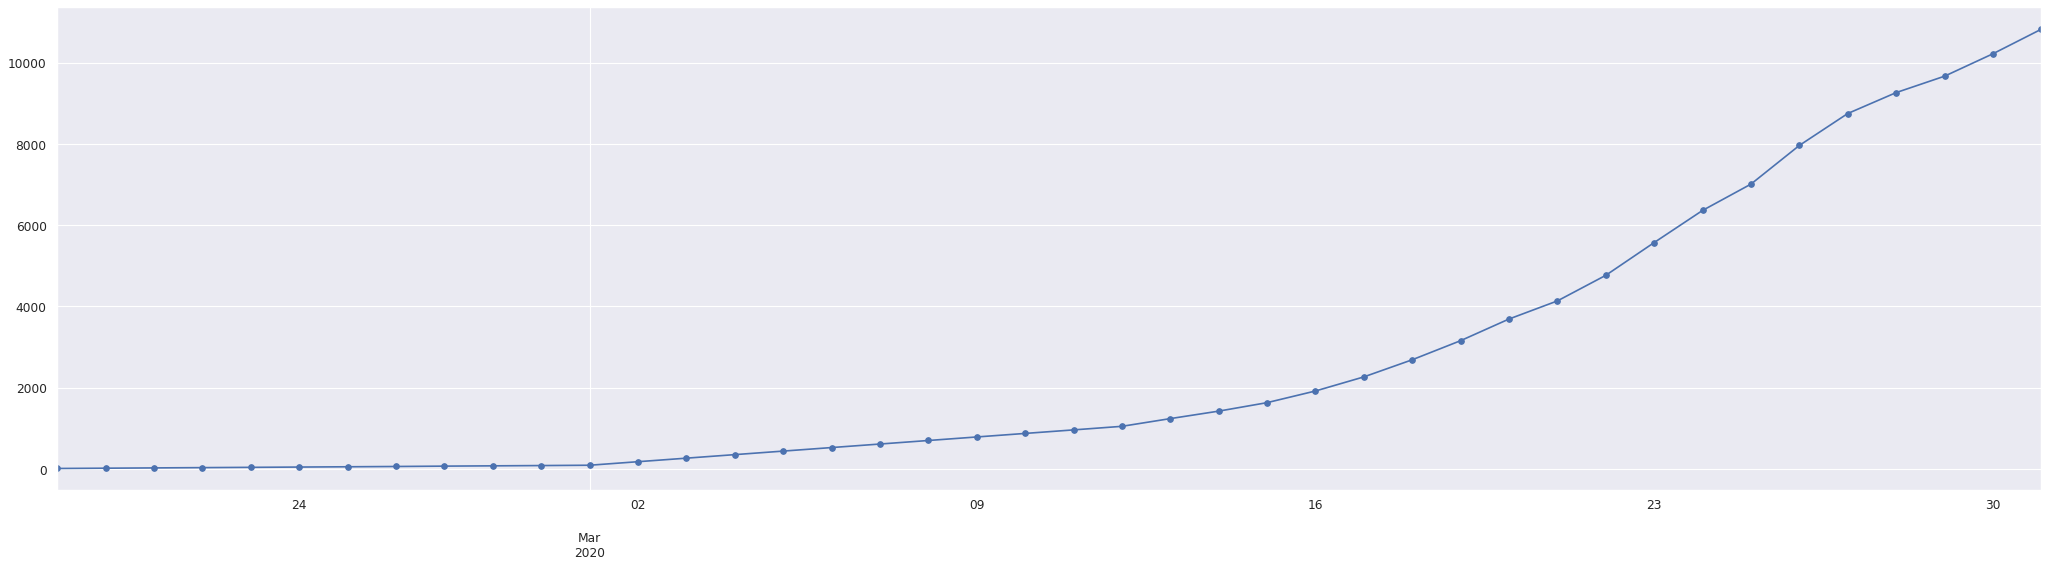

In [9]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
austria_mortality_analysis.prepend_df.confirmed.plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5)

In [10]:
austria_df = austria_mortality_analysis.prepend_df.confirmed.reset_index(drop=True)
# .reset_index(drop=True).reset_index(name='x')
austria_df.index.name = 'x'
austria_df = austria_df.reset_index().astype(np.float)
austria_df.index = austria_mortality_analysis.prepend_df.index
austria_df.head()

,x,confirmed
2020-02-19,0.0,7.0
2020-02-20,1.0,14.0
2020-02-21,2.0,21.0
2020-02-22,3.0,28.0
2020-02-23,4.0,35.0


In [11]:
last_value_austria = float(austria_df.confirmed.iloc[-1])
last_value_austria

10823.0

In [12]:
with pm.Model() as sigmoid_model_austria:
    # Define priors
    sma_scale        = pm.Gamma('scale', mu=2*last_value_austria, sigma=2*last_value_austria, testval=last_value_austria)
    # sma_scale        = pm.Uniform('scale', lower=0.0, upper=5.0 * last_value_austria)
    sma_intercept    = pm.Normal('a', 0, sd=100.0)
    sma_coeff        = pm.Exponential('b', lam=4.0)
    sma_sigma        = pm.HalfCauchy('sigma', beta=100.0)
    sma_sigmoid      = sma_scale * pm.math.sigmoid(sma_intercept + sma_coeff * austria_df['x'])
    sma_nu           = pm.Uniform('nu', lower=1, upper=100)

    # Define likelihood
    sma_likelihood   = pm.StudentT('y', mu=sma_sigmoid, sd=sma_sigma, nu=sma_nu, observed=austria_df['confirmed'])
    
    sma_trace = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, b, a, scale]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [01:00<00:00, 466.24draws/s]
The acceptance probability does not match the target. It is 0.8876987873385659, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7205883263208464, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [13]:
sma_df = pm.summary(sma_trace)
sma_df

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-6.877,0.123,-7.103,-6.639,0.002,0.001,4548.0,4542.0,4561.0,6398.0,1.0
scale,14793.908,475.712,13933.955,15673.754,6.870,4.858,4795.0,4795.0,4697.0,6567.0,1.0
b,0.193,0.005,0.184,0.203,0.000,0.000,4285.0,4274.0,4284.0,5751.0,1.0
sigma,124.458,19.700,90.684,163.579,0.727,0.514,735.0,735.0,1520.0,515.0,1.0
nu,47.495,29.647,1.001,93.739,0.473,0.335,3921.0,3921.0,1459.0,545.0,1.0


In [14]:
a     = sma_df.loc['a', 'mean']
b     = sma_df.loc['b', 'mean']
scale = sma_df.loc['scale', 'mean']
a,b,scale

(-6.877, 0.193, 14793.908)

In [15]:
austria_df['sigmoid_fit'] = scale/(1+np.exp(-(b*austria_df.x + a)))

In [16]:
austria_df.iloc[int(-sma_df.loc['a', 'mean']/sma_df.loc['b', 'mean']) + 1]

x                36.000000
confirmed      7961.000000
sigmoid_fit    7659.435612
Name: 2020-03-26 00:00:00, dtype: float64

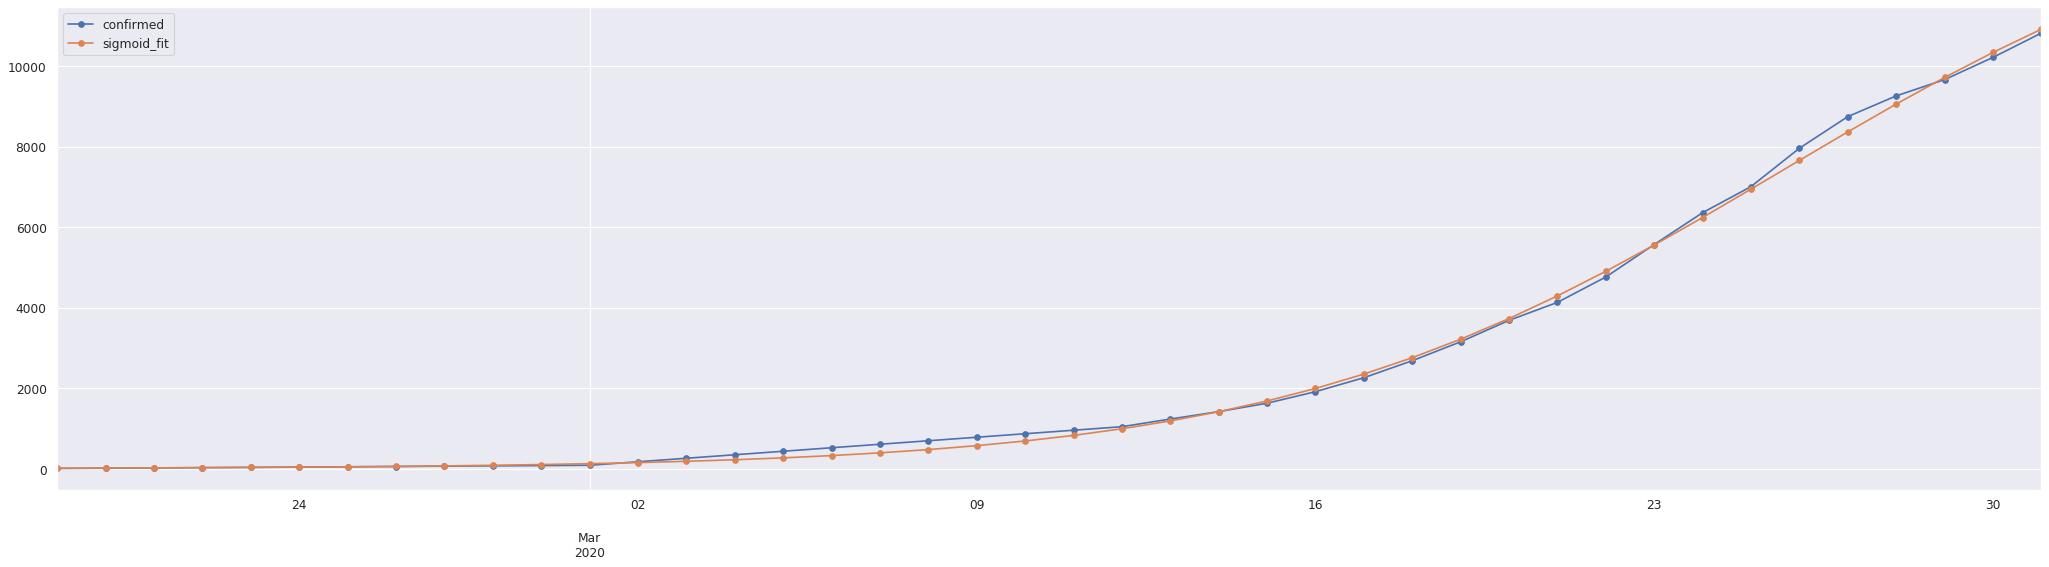

In [17]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
austria_df[['confirmed', 'sigmoid_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5)

In [18]:
with pm.Model() as exponential_model_austria:
    # Define priors
    ema_scale        = pm.Gamma('scale', mu=2*last_value_austria, sigma=2*last_value_austria, testval=last_value_austria)
    # sma_scale        = pm.Uniform('scale', lower=0.0, upper=5.0 * last_value_austria)
    ema_coeff        = pm.Exponential('b', lam=4.0)
    ema_sigma        = pm.HalfCauchy('sigma', beta=100.0)
    ema_exp          = ema_scale * pm.math.exp(ema_coeff * austria_df['x'])
    ema_nu           = pm.Uniform('nu', lower=1, upper=100)

    # Define likelihood
    ema_likelihood   = pm.StudentT('y', mu=ema_exp, sd=ema_sigma, nu=ema_nu, observed=austria_df['confirmed'])
    
    ema_trace = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, b, scale]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:46<00:00, 602.49draws/s]
The acceptance probability does not match the target. It is 0.6866006929447163, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [19]:
ema_df = pm.summary(ema_trace)
ema_df

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
scale,48.969,4.781,40.181,57.499,0.097,0.069,2426.0,2426.0,2385.0,5154.0,1.0
b,0.143,0.003,0.137,0.149,0.000,0.000,2246.0,2238.0,2297.0,5143.0,1.0
sigma,82.234,18.916,48.819,116.926,0.299,0.211,4001.0,4001.0,3743.0,3970.0,1.0
nu,1.185,0.169,1.000,1.493,0.002,0.001,7053.0,7053.0,4888.0,3962.0,1.0


In [20]:
b     = ema_df.loc['b', 'mean']
scale = ema_df.loc['scale', 'mean']
b, scale

(0.143, 48.969)

In [21]:
austria_df['exp_fit'] = scale * np.exp(b*austria_df.x)

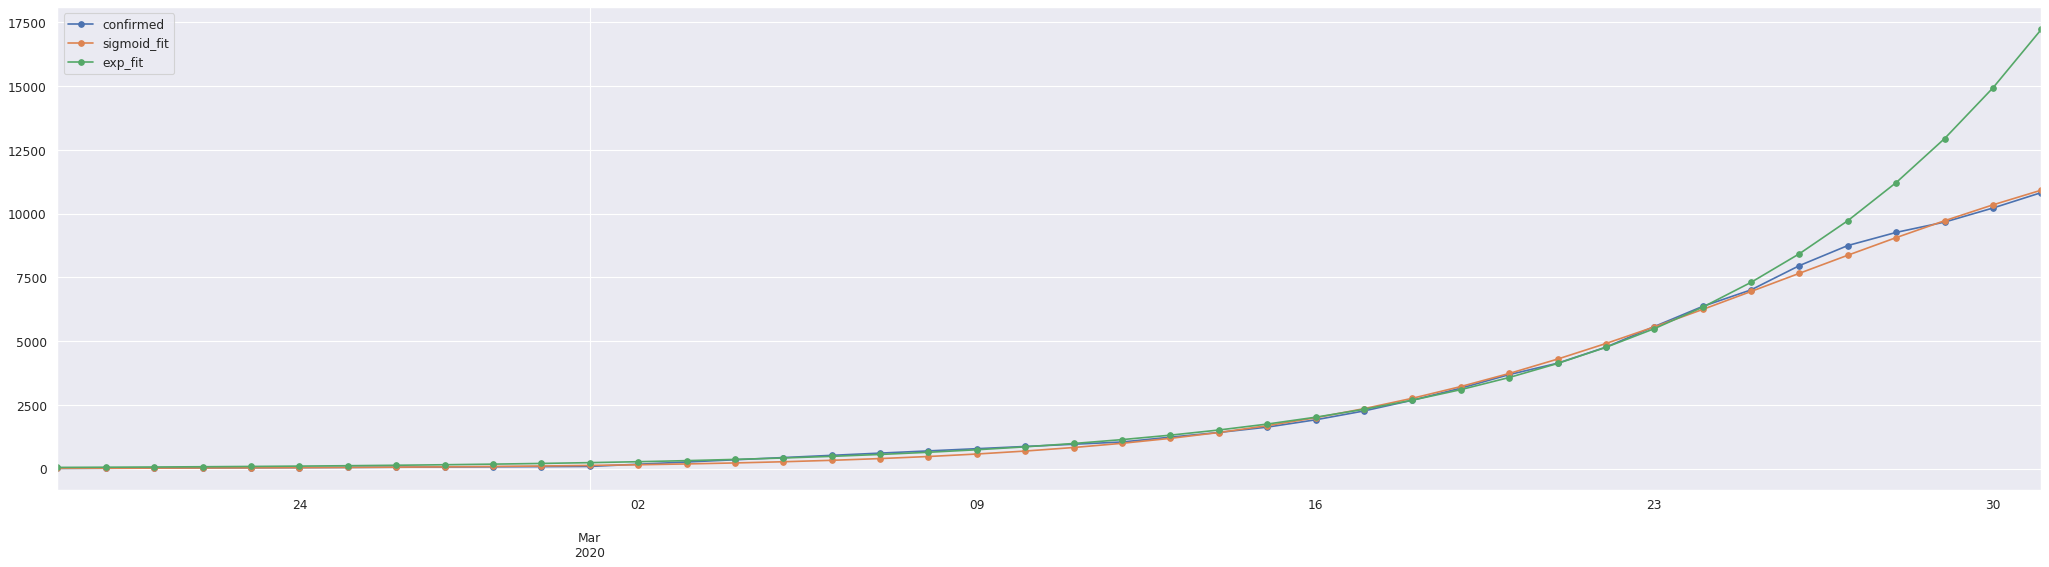

In [22]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
austria_df[['confirmed', 'sigmoid_fit', 'exp_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5)

In [23]:
sigmoid_model_austria.name     = 'sigmoid_model_austria'
exponential_model_austria.name = 'exponential_model_austria'
model_trace_dict = {sigmoid_model_austria: sma_trace, exponential_model_austria: ema_trace}
dfwaic = pm.compare(model_trace_dict, ic='WAIC')
dfwaic

/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
<pymc3.model.Model object at 0x7fa873db9f28>,0,-267.8,6.10686,0,0.999512,5.52317,0,True,log
<pymc3.model.Model object at 0x7fa85bcfd208>,1,-300.163,11.9881,32.3623,0.000487857,14.8919,14.1386,True,log


In [24]:
hex(id(sigmoid_model_austria))

'0x7fa873db9f28'

In [25]:
hex(id(exponential_model_austria))

'0x7fa85bcfd208'

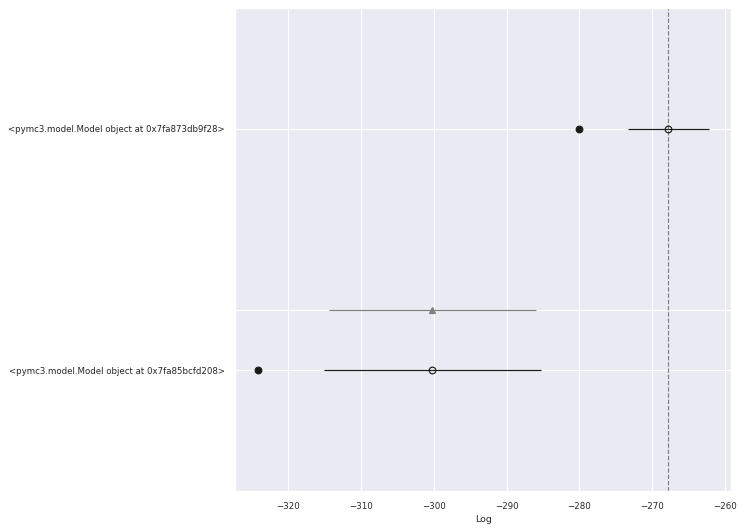

In [26]:
fig = plt.figure(figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
pm.compareplot(dfwaic, ax=ax)

In [27]:
df = covid19.get_cases_by_region()
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-27,49039,6932,323,5828,1254,61
2020-03-28,54268,8481,398,5229,1549,75
2020-03-29,58655,9291,456,4387,810,58
2020-03-30,62526,13500,565,3871,4209,109
2020-03-31,67074,15826,702,4548,2326,137


In [7]:
germany_mortality_analysis = covid19.MortalityAnalysis('Germany', first_date=pd.to_datetime('2020-03-09'))
germany_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-28,54268,8481,398,5229,1549,75
2020-03-29,58655,9291,456,4387,810,58
2020-03-30,62526,13500,565,3871,4209,109
2020-03-31,67074,15826,702,4548,2326,137
2020-04-01,72956,19175,867,5882,3349,165


,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-09,1176,18,2,136,0,2
2020-03-10,1457,18,2,281,0,0
2020-03-11,1908,25,3,451,7,1
2020-03-12,2750,25,6,842,0,3
2020-03-13,3675,46,8,925,21,2
2020-03-14,4585,46,9,910,0,1
2020-03-15,5813,46,13,1228,0,4
2020-03-16,7272,67,17,1459,21,4
2020-03-17,9360,71,26,2088,4,9
2020-03-18,12327,105,28,2967,34,2


In [9]:
ldf = germany_mortality_analysis.df[germany_mortality_analysis.df.death > 0].copy()
germany_df = ldf.confirmed.reset_index(drop=True)
# .reset_index(drop=True).reset_index(name='x')
germany_df.index.name = 'x'
germany_df = germany_df.reset_index().astype(np.float)
germany_df.index = ldf.index
germany_df.head()

,x,confirmed
2020-03-09,0.0,1176.0
2020-03-10,1.0,1457.0
2020-03-11,2.0,1908.0
2020-03-12,3.0,2750.0
2020-03-13,4.0,3675.0


In [10]:
last_value_germany = float(germany_df.confirmed.iloc[-1])
last_value_germany

72956.0

In [11]:
with pm.Model() as sigmoid_model_germany:
    # Define priors
    smg_scale        = pm.Gamma('scale', mu=2*last_value_germany, sigma=2*last_value_germany, testval=last_value_germany)
    # sma_scale        = pm.Uniform('scale', lower=0.0, upper=5.0 * last_value_austria)
    smg_intercept    = pm.Normal('a', 0, sd=100.0)
    smg_coeff        = pm.Exponential('b', lam=4.0)
    smg_sigma        = pm.HalfCauchy('sigma', beta=100.0)
    smg_sigmoid      = smg_scale * pm.math.sigmoid(smg_intercept + smg_coeff * germany_df['x'])
    smg_nu           = pm.Uniform('nu', lower=1, upper=100)

    # Define likelihood
    smg_likelihood   = pm.StudentT('y', mu=smg_sigmoid, sd=smg_sigma, nu=smg_nu, observed=germany_df['confirmed'])
    
    smg_trace = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, b, a, scale]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:39<00:00, 707.24draws/s]
The acceptance probability does not match the target. It is 0.8827552492538454, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [12]:
smg_df = pm.summary(smg_trace)
smg_df

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-3.926,0.063,-4.044,-3.809,0.001,0.001,4250.0,4220.0,4375.0,4534.0,1.0
scale,92479.234,3181.460,86223.611,98327.733,48.406,34.230,4320.0,4320.0,4241.0,3989.0,1.0
b,0.224,0.007,0.211,0.238,0.000,0.000,3432.0,3352.0,3617.0,3472.0,1.0
sigma,894.778,174.172,595.884,1262.364,3.088,2.184,3182.0,3182.0,3757.0,1620.0,1.0
nu,47.723,29.517,1.107,93.816,0.378,0.268,6082.0,6082.0,3962.0,1760.0,1.0


In [13]:
a     = smg_df.loc['a', 'mean']
b     = smg_df.loc['b', 'mean']
scale = smg_df.loc['scale', 'mean']
a,b,scale

(-3.926, 0.224, 92479.234)

In [14]:
germany_df['sigmoid_fit'] = scale/(1+np.exp(-(b*germany_df.x + a)))

In [15]:
# b*x + a = 0
# => x = -a / b
-a/b

17.526785714285715

In [16]:
germany_df.iloc[int(-smg_df.loc['a', 'mean']/smg_df.loc['b', 'mean']) + 1]

x                 18.000000
confirmed      49039.000000
sigmoid_fit    48688.024605
Name: 2020-03-27 00:00:00, dtype: float64

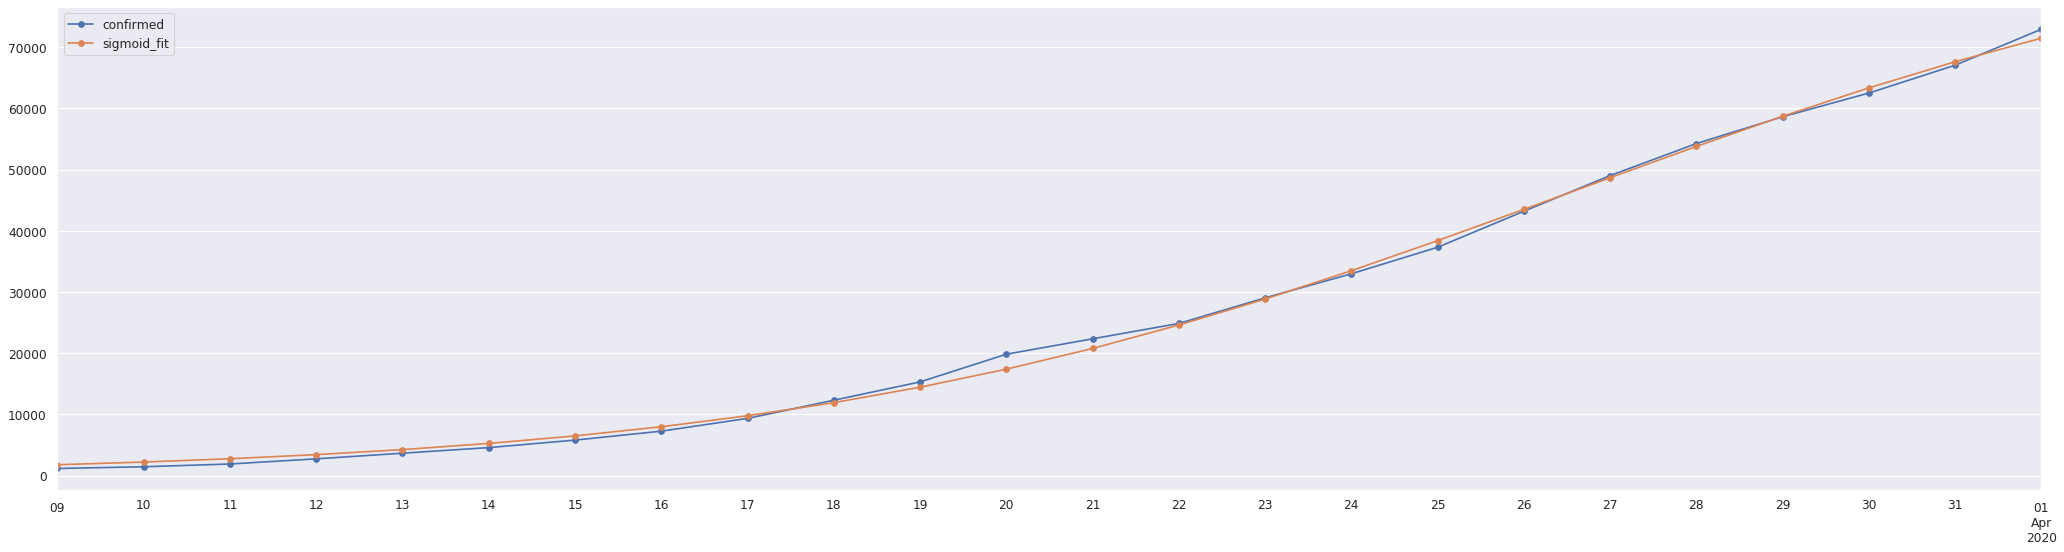

In [17]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
germany_df[['confirmed', 'sigmoid_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5)